In [ ]:
%pip install cartopy

  Obtaining dependency information for cartopy from https://files.pythonhosted.org/packages/04/87/8dc9249e67c635a5c08ae81d4243a1ad69a1b91b703d3ab9be7fa78efc2b/Cartopy-0.24.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for shapely>=1.8 from https://files.pythonhosted.org/packages/a2/17/e09357274699c6e012bbb5a8ea14765a4d5860bb658df1931c9f90d53bd3/shapely-2.1.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for pyshp>=2.3 from https://files.pythonhosted.org/packages/98/2f/68116db5b36b895c0450e3072b8cb6c2fac0359279b182ea97014d3c8ac0/pyshp-2.3.1-py2.py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/56.0 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━ 51.2/56.0 kB 2.3 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 1.4 MB/s eta 0:00:00
  Obtaining dependency information for pyproj>=3.3.1 from https://files.pyth

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, round as spark_round, to_date, avg, sum as spark_sum, count
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import udf
from pyspark.sql.types import BooleanType
from pyspark.sql.functions import abs as spark_abs, col, round as spark_round, udf
from pyspark.sql.functions import to_timestamp
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import pandas as pd

In [ ]:
# Khởi tạo SparkSession
spark = SparkSession.builder \
    .appName("EarthquakeAnalysis") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .getOrCreate()

In [ ]:
# Đọc dữ liệu parquet
df = spark.read.parquet("abfss://gold@bigdatacuoiky.dfs.core.windows.net/earthquake_events_gold/")
df.show(5)
df.printSchema()
df.describe().show()
df.columns

+------------+------------+-----------+-----------+--------------------+--------------------+---+----+-------+--------------------+--------------------+---------+
|          id|   longitude|   latitude|  elevation|               title|   place_description|sig| mag|magType|                time|             updated|sig_class|
+------------+------------+-----------+-----------+--------------------+--------------------+---+----+-------+--------------------+--------------------+---------+
|ak0219pcfvx9|   -155.2341|     65.771|        4.0|M 0.9 - 54 km E o...|54 km E of Huslia...| 12| 0.9|     ml|2021-07-30 23:59:...|2021-08-13 03:19:...|      Low|
|  ok2021ovmz|-97.50583333|36.97083333|       3.28|M 1.9 - 9 km WSW ...|9 km WSW of Hunne...| 53|1.85|     ml|2021-07-30 23:54:...|2021-08-02 14:25:...|      Low|
|  nc73602856|-119.5573333|    38.4215|       5.14|M 1.6 - 26km ENE ...|26km ENE of Darda...| 39|1.59|     md|2021-07-30 23:54:...|2021-08-07 06:38:...|      Low|
|  tx2021ovmy|-98.6308

['id',
 'longitude',
 'latitude',
 'elevation',
 'title',
 'place_description',
 'sig',
 'mag',
 'magType',
 'time',
 'updated',
 'sig_class']

In [ ]:
# 2. Tiền xử lý thời gian và loại bỏ dữ liệu lỗi
df = df.withColumn('time', to_timestamp(col('time')))

# Loại bỏ null values
df = df.filter(
    col('time').isNotNull() &
    col('mag').isNotNull() &
    col('longitude').isNotNull() &
    col('latitude').isNotNull() &
    col('sig').isNotNull()
)

# Loại bỏ duplicates
df = df.dropDuplicates()

# Lọc dữ liệu hợp lệ
df = df.filter(
    (col('mag') >= 0) & (col('mag') <= 10) &
    (col('longitude') >= -180) & (col('longitude') <= 180) &
    (col('latitude') >= -90) & (col('latitude') <= 90)
)

print("Số dòng sau khi làm sạch:", df.count())

Số dòng sau khi làm sạch: 775908


In [ ]:
# Thêm cột thời gian dạng timestamp và các đặc trưng thời gian
from pyspark.sql.functions import year, month, dayofyear, weekofyear, quarter, hour, dayofweek

df = df.withColumn('time', col('time').cast('timestamp'))
df = df.withColumn('hour', hour(col('time'))) \
       .withColumn('dayofweek', dayofweek(col('time'))) \
       .withColumn('dayofyear', dayofyear(col('time'))) \
       .withColumn('month', month(col('time'))) \
       .withColumn('weekofyear', weekofyear(col('time'))) \
       .withColumn('quarter', quarter(col('time'))) \
       .withColumn('year', year(col('time')))

# Thêm lat_bin và lon_bin vào DataFrame gốc
df = df.withColumn('lat_bin', spark_round(col('latitude'))) \
       .withColumn('lon_bin', spark_round(col('longitude')))

In [ ]:
# Lấy tập nhỏ để giảm tải
df = df.limit(150000)

In [ ]:
# Xác định các vùng hoạt động ít
region_activity = df.groupBy('lat_bin', 'lon_bin').count()
activity_counts_pd = region_activity.toPandas()
activity_threshold = np.percentile(activity_counts_pd['count'], 40)
low_activity_regions = activity_counts_pd[activity_counts_pd['count'] < activity_threshold]
low_activity_set = set(zip(low_activity_regions['lat_bin'], low_activity_regions['lon_bin']))

print(f"Activity threshold (40th percentile): {activity_threshold}")
print(f"Số vùng ít hoạt động: {len(low_activity_regions)}")

Activity threshold (40th percentile): 2.0
Số vùng ít hoạt động: 1478


In [ ]:
# Chọn đặc trưng
feature_cols = ['longitude', 'latitude', 'dayofyear', 'month', 'year', 'sig']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

data = assembler.transform(df).select('features', 'mag', 'time', 'longitude', 'latitude', 'lat_bin', 'lon_bin')

In [ ]:
# Chia train-test
train_count = int(data.count() * 0.8)
train_data = data.limit(train_count)
test_data = data.subtract(train_data)

In [ ]:
 # Xây dựng mô hình Random Forest
rf = RandomForestRegressor(featuresCol='features', labelCol='mag', seed=42)

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [100]) \
    .addGrid(rf.maxDepth, [10, 20]) \
    .addGrid(rf.minInstancesPerNode, [1]) \
    .addGrid(rf.minInfoGain, [0.0]) \
    .build()

evaluator = RegressionEvaluator(labelCol='mag', predictionCol='prediction', metricName='r2')

crossval = CrossValidator(estimator=rf,
                         estimatorParamMaps=paramGrid,
                         evaluator=evaluator,
                         numFolds=3,
                         seed=42)

cvModel = crossval.fit(train_data)

print("Best model params:", cvModel.bestModel.extractParamMap())

predictions = cvModel.transform(test_data)

Best model params: {Param(parent='RandomForestRegressor_4fcf22d66da4', name='bootstrap', doc='Whether bootstrap samples are used when building trees.'): True, Param(parent='RandomForestRegressor_4fcf22d66da4', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False, Param(parent='RandomForestRegressor_4fcf22d66da4', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10, Param(parent='RandomForestRegressor_4fcf22d66da4', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tre

In [ ]:
# 6. Dự đoán và đánh giá
best_model = cvModel.bestModel
train_predictions = best_model.transform(train_data)
test_predictions = best_model.transform(test_data)

# Tính các metrics
train_r2 = evaluator.evaluate(train_predictions)
test_r2 = evaluator.evaluate(test_predictions)

mae_evaluator = RegressionEvaluator(labelCol="mag", predictionCol="prediction", metricName="mae")
rmse_evaluator = RegressionEvaluator(labelCol="mag", predictionCol="prediction", metricName="rmse")

test_mae = mae_evaluator.evaluate(test_predictions)
test_rmse = rmse_evaluator.evaluate(test_predictions)

print(f"Test MAE: {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R2: {test_r2:.4f}")
print(f"Train R2: {train_r2:.4f}")

Test MAE: 0.0437
Test RMSE: 0.0946
Test R2: 0.9935
Train R2: 0.9958


In [ ]:
# Tìm anomaly
predictions = test_predictions.withColumn('error', spark_abs(col('mag') - col('prediction')))
errors_pd = predictions.select('error').toPandas()
error_threshold = np.percentile(errors_pd['error'], 95)
mag_threshold = df.approxQuantile('mag', [0.85], 0.01)[0]

print(f"Error threshold (95th percentile): {error_threshold:.4f}")
print(f"Magnitude threshold (85th percentile): {mag_threshold:.4f}")

# Hàm kiểm tra vùng ít hoạt động
def is_low_activity(lat_bin, lon_bin):
    return (lat_bin, lon_bin) in low_activity_set
udf_is_low_activity = udf(is_low_activity, BooleanType())

# Thêm cột kiểm tra vùng ít hoạt động
predictions = predictions.withColumn('in_low_activity', udf_is_low_activity(col('lat_bin'), col('lon_bin')))

# Lọc các trận bất thường
final_anomalies = predictions.filter(
    (col('mag') >= mag_threshold) &
    (col('error') >= error_threshold) &
    (col('in_low_activity') == True)
)

anomaly_count = final_anomalies.count()
print(f"Số trận động đất bất thường: {anomaly_count}")

# Xem qua các trận động đất bất thường
final_anomalies_pd = final_anomalies.select('longitude', 'latitude', 'mag', 'time').toPandas()
final_anomalies_pd['time'] = pd.to_datetime(final_anomalies_pd['time'])
final_anomalies_pd = final_anomalies_pd.sort_values(by='time', ascending=True)
final_anomalies_pd['date'] = final_anomalies_pd['time'].dt.date
print(final_anomalies_pd[['date', 'mag', 'longitude', 'latitude',]])

Error threshold (95th percentile): 0.1595
Magnitude threshold (85th percentile): 2.8000
Số trận động đất bất thường: 80
          date   mag   longitude  latitude
38  2020-02-28  4.00  101.887700   21.1315
77  2020-04-08  4.60 -104.175200  -41.6822
69  2020-05-13  5.00  139.003800   42.7419
73  2020-05-22  4.60   85.510700   32.8636
61  2020-07-14  4.60  179.681100  -65.2047
..         ...   ...         ...       ...
48  2024-12-29  2.90  -84.756500   41.2803
36  2025-01-10  5.60  -77.468300    5.9461
59  2025-01-15  3.02 -154.911833   20.5695
7   2025-01-22  4.60  -13.503400  -27.7408
11  2025-02-19  3.00 -111.020100   34.3126

[80 rows x 4 columns]


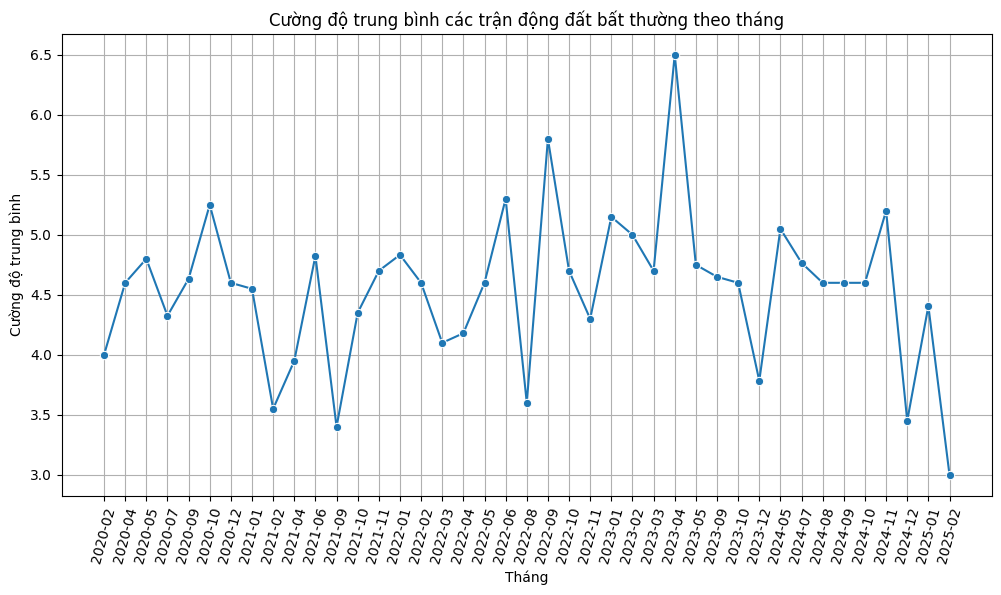

In [ ]:
# Chuyển sang Pandas để vẽ biểu đồ
final_anomalies_pd = final_anomalies.select('time', 'longitude', 'latitude', 'mag', 'error').toPandas()
final_anomalies_pd['time'] = pd.to_datetime(final_anomalies_pd['time'])
final_anomalies_pd['month'] = final_anomalies_pd['time'].dt.to_period('M').astype(str)

monthly_avg_mag = final_anomalies_pd.groupby('month')['mag'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_avg_mag, x='month', y='mag', marker='o')
plt.title('Cường độ trung bình các trận động đất bất thường theo tháng')
plt.xlabel('Tháng')
plt.ylabel('Cường độ trung bình')
plt.grid(True)
plt.xticks(rotation=75)
plt.show()

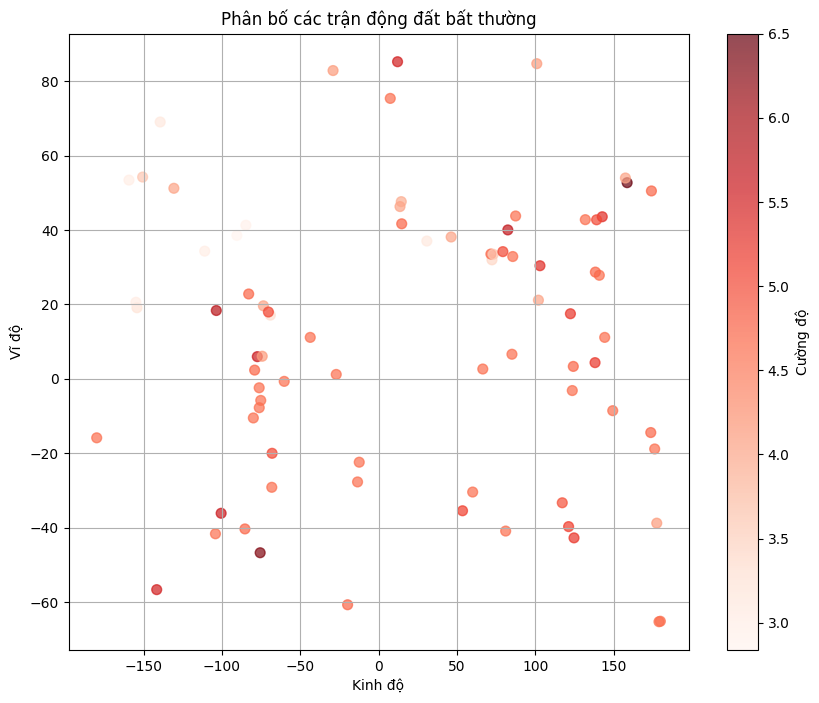

In [ ]:
# Phân bố động đất bất thường biểu diễn với scatterplot
final_anomalies_pd = final_anomalies.select('longitude', 'latitude', 'mag').toPandas()

plt.figure(figsize=(10,8))
sc = plt.scatter(
    final_anomalies_pd['longitude'],
    final_anomalies_pd['latitude'],
    c=final_anomalies_pd['mag'],
    cmap='Reds',
    s=50,
    alpha=0.7
)
plt.colorbar(sc, label='Cường độ')
plt.title('Phân bố các trận động đất bất thường')
plt.xlabel('Kinh độ')
plt.ylabel('Vĩ độ')
plt.grid(True)
plt.show()

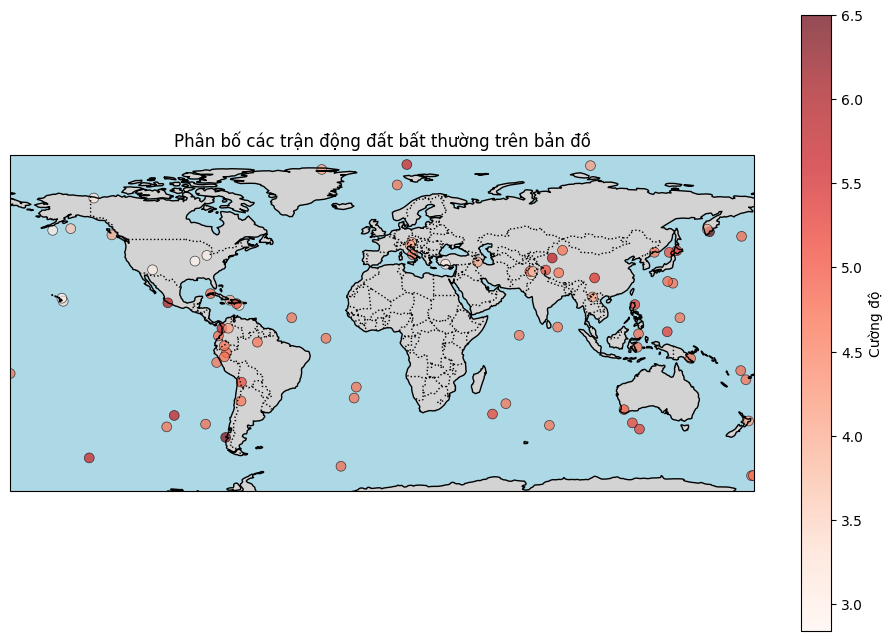

In [ ]:
plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
sc = ax.scatter(
    final_anomalies_pd['longitude'],
    final_anomalies_pd['latitude'],
    c=final_anomalies_pd['mag'],
    cmap='Reds',
    s=50,
    alpha=0.7,
    edgecolors='k',
    linewidth=0.5,
    transform=ccrs.PlateCarree()
)
plt.colorbar(sc, label='Cường độ', orientation='vertical', pad=0.05)
plt.title('Phân bố các trận động đất bất thường trên bản đồ')
plt.show()
